In [1]:
import numpy as np
import torch
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from ml import BrainDataset, PolicyEstimator, reinforce, sample_batch_fn
from cust_plot import plot

In [2]:
# Input Parameters
num_fns = 9
res = 68
subj = np.arange(484)
epochs = 1
batch = 1
sample = 1
hidden_units = 20
lr = 0.005
save_path = None
load_path = None
log = True

In [3]:
# Read brain data (change file locations as necessary)
sc = loadmat(f'data/subjfiles_SC{res}.mat')
fc = loadmat(f'data/subjfiles_FC{res}.mat')
sc = np.array([sc[f's{str(z+1).zfill(3)}'] for z in subj])
fc = np.array([fc[f's{str(z+1).zfill(3)}'] for z in subj])
euc_dist = loadmat('data/euc_dist.mat')[f'eu{res}']
hubs = np.loadtxt(f'data/hubs_{res}.txt', dtype=np.int, delimiter=',')
regions = np.loadtxt(f'data/regions_{res}.txt', dtype=np.int, delimiter=',')

In [4]:
# Init network parameters
pe = PolicyEstimator(res, num_fns, hidden_units=hidden_units)
opt = torch.optim.Adam(pe.network.parameters(), lr=lr)

In [5]:
# Init new/load previous training data
if load_path:
    # Load from checkpoint
    plt_data = torch.load(load_path)
    pe.network.load_state_dict(plt_data.pop('model_state_dict'))
    opt.network.load_state_dict(plt_data.pop('optimizer_state_dict'))
else:
    # New
    plt_data = {
        'epochs': 0,
        'rewards': [],
        'success': [],
        'mu': [[] for _ in range(num_fns)],
        'sig': [[] for _ in range(num_fns)]}
    plt_data['train_idx'], plt_data['test_idx'] = train_test_split(subj, train_size=0.7) if len(subj) > 1 else (subj, [])

In [6]:
# Train / test split
train_idx, test_idx = plt_data['train_idx'], plt_data['test_idx']
train_data = BrainDataset(sc[train_idx], fc[train_idx], euc_dist, hubs, regions)
test_data =  BrainDataset(sc[test_idx],  fc[test_idx],  euc_dist, hubs, regions)

In [7]:
# Train network
reinforce(pe, opt, train_data, epochs=epochs, batch=batch, sample=sample, lr=lr, plt_data=plt_data, log=log, save_path=save_path)

-- Epoch 1 --
Done


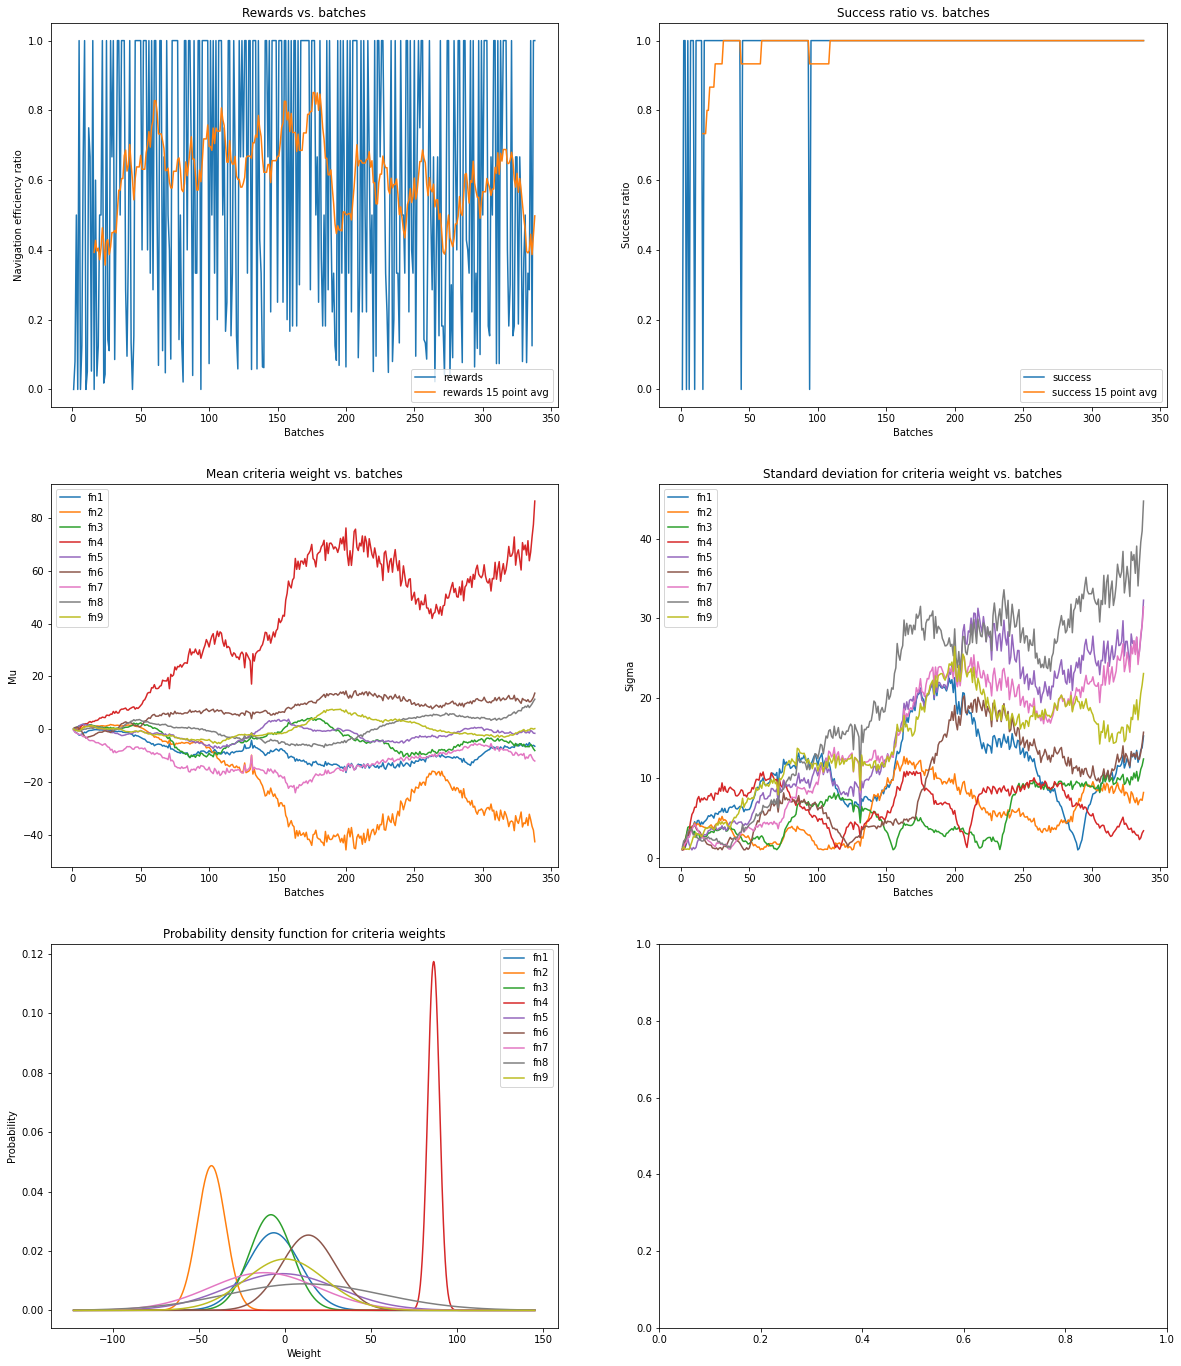

In [8]:
# Visualise
plot(plt_data=plt_data, num_fns=num_fns, plt_avg=15)

In [ ]:
# Evaluate
fn_weights = [mu[-1] for mu in plt_data['mu']]
test_rewards = np.zeros(len(test_data))
test_success = np.zeros(len(test_data))
for i, (_, sp, pp, sample_idx) in enumerate(test_data):
    pp.fn_weights = fn_weights
    test_rewards[i], test_success[i] = sample_batch_fn(pp, sp, sample, sample_idx)

test_rewards = test_rewards.mean()
test_success = test_success.mean()
print(test_rewards, test_success)